# Estimation du prix d'un bien immobilier à Paris selon ses caractéristiques #

## Introduction ##

### Contexte du marché parisien ###

La trajectoire des prix immobiliers à Paris semblait inarrêtable. Après un doublement en dix ans, suivi d'une légère correction en 2015, le marché a atteint un sommet historique de 10 310 €/m² au premier trimestre 2023. Cette hausse s’explique notamment par des conditions de financement très favorables : entre 2015 et 2019, les taux d'intérêt moyens pour un crédit immobilier sur 20 ans étaient autour de 2,35 %, chutant à 1,25-1,5 % en 2020-2021 grâce aux politiques économiques liées à la COVID-19.
Cependant, cette dynamique s'est inversée en 2023. Les transactions ont chuté de 23 % au premier trimestre 2024 (en glissement annuel), et les prix ont reculé de 7,9 % en juin 2024, atteignant 9 190 €/m². Cette baisse est liée à la forte hausse des taux d’intérêt, passés de 1 % en 2021 à plus de 4 % fin 2023, et au durcissement des règles d’octroi des prêts, limitant le taux d’endettement à 35 % et la durée des emprunts à 25 ans. Ces facteurs ont réduit la demande immobilière, laissant le marché parisien à la traîne par rapport à d’autres métropoles européennes comme Madrid ou Lisbonne.
Dans ce contexte, de nombreux ménages s’interrogent : faut-il vendre maintenant ou attendre une reprise des prix ? Pour éclairer ces décisions, ce projet propose un modèle d’estimation des prix immobiliers à Paris. En analysant les principales caractéristiques influençant la valeur d’un bien, nous chercherons à mieux comprendre les dynamiques du marché et à fournir des outils d’aide à la décision.

## I. Scraping ##

In [42]:
## APPELER LE FICHIER OU ON A FAIT LE SCRAPING  

Cf fichier scraping dans le repo GitHub (où ce trouve notre code) 

## II. Prétraitement des données ##

In [ ]:
## Code Maxime 

## III. Statistiques descriptives & représentations graphiques - cartes ##

In [4]:
import s3fs
import pandas as pd

# Initialize the S3 filesystem with your custom endpoint
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

# Define your bucket and file path
MY_BUCKET = "jhajjar"
FILE_PATH_S3 = f"{MY_BUCKET}/Diffusion/clean_data.csv"

# Define a local path to download the file
LOCAL_FILE = "clean_data.csv"

# Step 1: Download the file from S3 to the local machine
try:
    fs.get(FILE_PATH_S3, LOCAL_FILE)
    print(f"File downloaded successfully to {LOCAL_FILE}.")
except Exception as e:
    print(f"Error downloading the file: {e}")
    # Optionally, you can exit or handle the error as needed
    # import sys
    # sys.exit(1)

# Step 2: Read the downloaded local file into a pandas DataFrame
try:
    df = pd.read_csv(LOCAL_FILE)
    print("File read into DataFrame successfully.")
except Exception as e:
    print(f"Error reading the CSV file: {e}")
    # Handle the error as needed

# (Optional) Display the DataFrame
print(df)

Error downloading the file: Access Denied.
File read into DataFrame successfully.
                                     id         type  nb_pieces  \
0                        apimo-85473173  Appartement          1   
1            hektor-Les-4-Quartiers-383  Appartement          1   
2          hektor-PARISLUXURYHOMES-4007  Appartement          5   
3                    ag754594-448898324       Studio          1   
4      keller-williams-1-34_1_53-180645  Appartement          2   
...                                 ...          ...        ...   
10096                    apimo-83966258  Appartement          1   
10097                ag755800-412953689  Appartement          1   
10098          century-21-202_480_27885  Appartement          3   
10099   netty-company34605jrw-appt-3212  Appartement          1   
10100                ag933277-381424162  Appartement          1   

                                                 loc  surface     prix  \
0            75001 Paris 1er (Châtelet 

Le dataframe issu du scraping comporte XXX entrées et 15 variables.\
La variable "id" correspond à l'identifiant unique que le site donne à chaque annonce. Il est souvent composé du nom de l'agence immobilière et d'une suite de nombres.\
La variable "type" décrit le type du bien immobilier : appartement, maison, studio, hôtel, loft/atelier/surface.\
la variable "Nb_chambre" correspond au nombre de pièces dans le logement. Par "pièces" on entend une pièce principal comme une chambre, un salon par exemple. (la cuisine / salle de bains / toilettes / couloirs / entrée n'étant pas comptés).\
La variable "loc1" indique la localisation du logement. Il ne s'agit pas d'une dénomination officielle mais de "sous-quartiers" arbitraires définis par un organisme nommé "Kelquartier", offrant des services d'informations aux plateformes immobilières.\
Comme vu précedemment, "loc2" correspond au quartier correspondant (grâce à l'API) et loc3 à l'arrondissement. Pour chacune de ces variables de localisation on a grâce à l'API de geopy, des longitudes (x) et latitudes correspondants (y)\
La variable "surface" est la superficie en mètre carré (loi Carrez) du logement. Finalement, la variable "prix" contient le prix en euros listé sur le site Bien'ici du bien immobilier en question.\

Dans un premier temps nous allons nous focaliser sur les données issues du scraping, puis, dans une seconde partie, nous allons exploiter les données géographiques enrichies. Ainsi, nous conservons, pour le moment, que les colonnes "id", "type", "nb_pièce", "prix", "surface", "loc1".

In [5]:
listings = df.drop(columns = ['loc2','loc3','loc1_x','loc2_x','loc1_y','loc2_y','loc3_x','loc3_y'])

Nous créons une colonne prix du m2. En effet, à des fins de comparaison, analyser simplement le prix n'a pas vraiment de sens sans prendre en compte la surface du bien.

In [6]:

listings.dropna(inplace=True)
listings["prix du m2"] = listings["prix"] / listings["surface"] #création de la colonne prix du m2

Afin de mieux appréhender notre dataframe, nous utilisons la fonction describe() de pandas. 

In [7]:
description_listings = listings.describe()
description_formattée = description_listings.map(lambda x: f"{x:.2f}")  # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
description_formattée

,nb_pieces,surface,prix,prix du m2
count,10101.00,10101.00,10101.00,10101.00
mean,2.78,64.83,747974.10,11041.04
std,1.54,48.89,800429.14,3599.74
min,1.00,4.00,22000.00,545.45
25%,2.00,32.00,325000.00,8962.26
50%,2.00,52.00,530000.00,10382.35
75%,4.00,82.00,850000.00,12285.71
max,17.00,448.00,15000000.00,52500.00


Avant d'interpréter les données, il est évident que plusieurs données résultent d'une anomalie/erreur de listing sur le site. En effet, une propriété contiendrait 90 pièces ce qui est impossible, surtout à Paris. Nous supprimons la ligne associée à cette erreur. De même le prix minimum de 22 0000 euros parait impossible pour les types de biens que nous avons retenu. Similairement, un prix du m2 de 545.54 n'est pas cohérent avec le marché parisien. 

In [8]:
listings = listings.drop(index = listings['nb_pieces'].idxmax()) # supprime le maximum de la colonne "nb_pieces"
listings = listings.drop(index = listings['prix'].idxmin()) # supprime le minimum de la colonne "prix"
listings = listings.drop(index = listings['prix du m2'].idxmin()) #supprime le minimum de la colonne "prix du m2"

In [9]:
def description_listings(listings : pd.DataFrame):
    description_listings = listings.describe()
    description_écrite = description_listings.map(lambda x: f"{x:.0f}")  # écriture non scientifique et arrondie à l'unité pour améliorer la clarté.
    description_formattée = description_listings.map(lambda x: f"{x:.2f}") # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
    print(f"Le logement médian à Paris fait {description_écrite.loc['50%','surface']} m2, comporte {description_écrite.loc['50%','nb_pieces']} pièces et coûte {description_écrite.loc['50%','prix']}€ soit {description_écrite.loc['50%','prix du m2']}€ du m2 (avec frais d'agence et notarial)")
    return description_formattée
description_listings(listings)

Le logement médian à Paris fait 52 m2, comporte 2 pièces et coûte 530000€ soit 10383€ du m2 (avec frais d'agence et notarial)


,nb_pieces,surface,prix,prix du m2
count,10098.00,10098.00,10098.00,10098.00
mean,2.78,64.79,747443.98,11042.15
std,1.53,48.78,797703.22,3596.15
min,1.00,4.00,25000.00,1203.70
25%,2.00,32.00,325000.00,8962.26
50%,2.00,52.00,530000.00,10383.48
75%,4.00,82.00,850000.00,12285.71
max,17.00,448.00,15000000.00,52500.00


Nous avons 8827 observations, une taille convenable pour pouvoir étudier les comportements statistiques asymptotiques et disposer d'une certaine représentativité du marché immobilier parisien.

Le nombre de pièces médian (3) et moyen (2.875) sont proches, ainsi, la distribution est centrée autour de trois pièces. Un immeuble représentatif parisien dispose (intuitivement) de deux chambres et un salon.

La surface moyenne et médiane sont quant à elles significativement éloignées. L'écart indique une distribution asymétrique vers la droite, quelques biens tirant la moyenne à la hausse. En effet un plancher minimal s'applique pour un bien immobilier (le minimum étant ici de 4 m2) tandis que le plafond peut être bien plus élevé (ici quasiment 700 m2 au maximum). D'un côte les studettes/locaux sont nombreux mais de l'autre les grands appartements haussmanniens et l'immobilier de luxe compensent largement.

Le même raisonnement peut être appliqué pour le prix où l'on observe un écart de quasiment 250 000 euros à la hausse ce qui indique que la distribution est fortement asymétrique vers la droite. On observe un écart type encore plus élevé que la moyenne qui dévoile une variabilité très importante dans les données. le prix du m2 (prix/surface) étant une fonction du prix, hérite de cette distribution asymétrique bien que dans une plus faible mesure.

Nous avons donc des distributions asymétriques à droite caractéristiques du marché immobilier parisien et que l'on retrouve dans d'autres centres économiques européens (comme Londres, Milan, Luxembourg, Munich, Genève).

 Afin de diminuer l'importance des valeurs extrêmes nous utilisons une transformation logarithmique pour le prix.

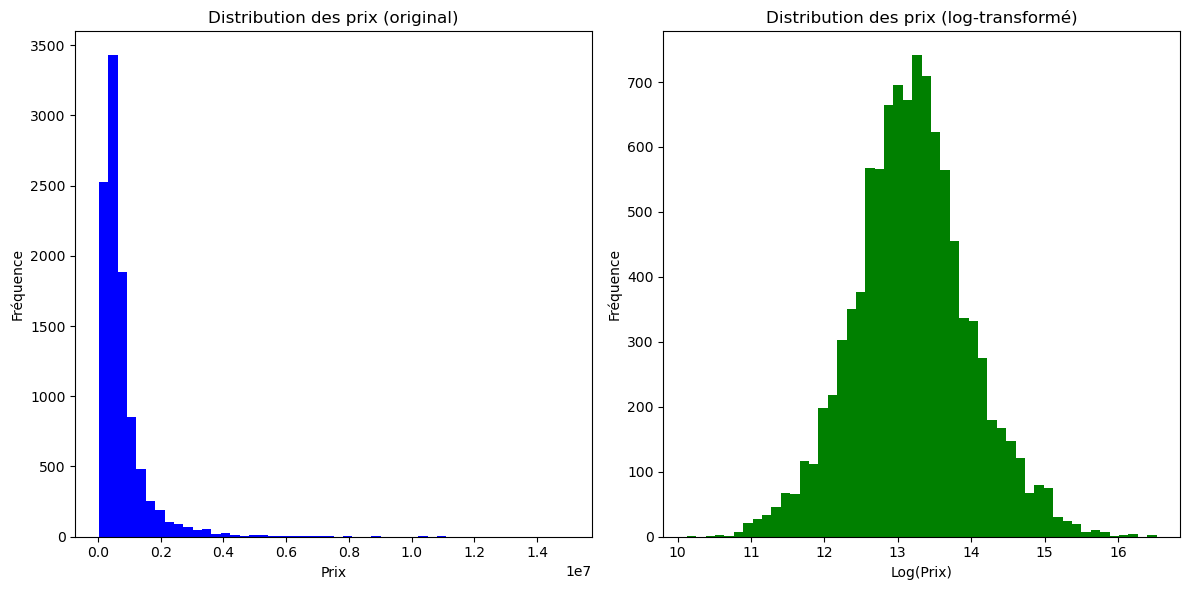

In [10]:
import numpy as np
import matplotlib.pyplot as plt
listings['log(prix)'] = np.log(listings['prix']) #transformation logarithmique grâce au np.log de numpy

import matplotlib.pyplot as plt

def graph_distribution_prix(listings: pd.DataFrame):
    """
    Trace les histogrammes de la distribution des prix avant et après transformation logarithmique.

    Args:
        listings (pd.DataFrame): DataFrame contenant les colonnes 'prix' et 'log(prix)'.
    """
    plt.figure(figsize=(12, 6))
    
    # Histogramme avant transformation
    plt.subplot(1, 2, 1)
    plt.hist(listings['prix'], bins=50, color='blue')
    plt.title('Distribution des prix (original)')
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    
    # Histogramme après transformation
    plt.subplot(1, 2, 2)
    plt.hist(listings['log(prix)'], bins=50, color='green')
    plt.title('Distribution des prix (log-transformé)')
    plt.xlabel('Log(Prix)')
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()

graph_distribution_prix(listings)


La log normalisation nous permet de passer d'une distribution fortement asymétrique à une distribution proche d'une gaussienne.

Procédons maintenant à l'analyse descriptive graphique de nos différentes variables.
Pour la variable surface, examinons la distribution du type de bien immobilier.

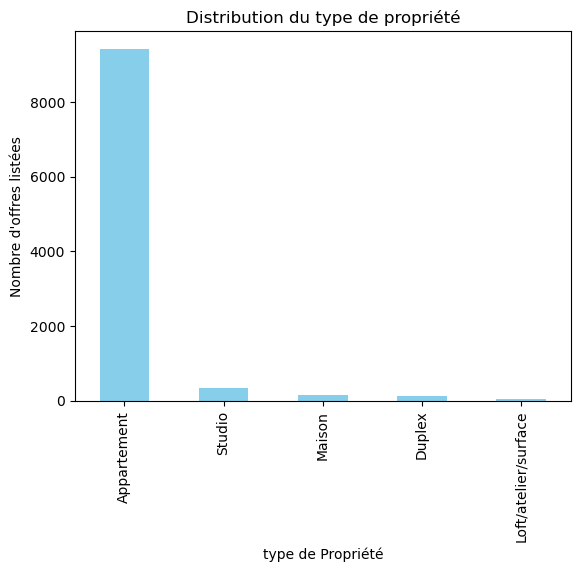

In [11]:
def graph_distribution_type(listings: pd.DataFrame):

    nombre_de_types = listings['type'].value_counts()
    nombre_de_types.plot(kind='bar', color='skyblue')
    plt.title('Distribution du type de propriété')
    plt.xlabel('type de Propriété')
    plt.ylabel("Nombre d'offres listées")
    plt.show()

graph_distribution_type(listings)


Sans surprises, la grande majorité des biens offerts sont des appartements, héritages des travaux dirigés par le Baron Haussmann entre 1853 et 1870.  
Cependant les annonces étant remplies par des agences, elles sont sujettes à erreur, surtout pour la catégorisation des biens. Par exemple, pour les petites surfaces, on trouve un certain nombre de studios qui sont catégorisés en tant qu'appartements et inversement. La dénomination choisie de "studio" ne respecte souvent pas la réglementation française (une surface habitable minimale de 9m, une hauteur sous plafond d'au moins 2,20 mètres, un volume habitable d'au moins 20 m3).

Pour les autres types (hors Loft/atelier/surface), intuitivement, ils devraient ajouter de la valeur aux biens. En effet, posséder une maison à Paris raisonne avec exclusivité, de même pour un duplex. Testons cet hypothèse.

In [12]:
from scipy.stats import ttest_ind


prix_maisons = listings[listings['type'] == 'Maison']['log(prix)']
prix_duplex = listings[listings['type'] == 'Duplex']['log(prix)']
prix_appartements = listings[listings['type'] == 'Appartement']['log(prix)']
stat, p_value = ttest_ind(prix_maisons, prix_appartements, equal_var=False)
stat2, p_value2 = ttest_ind(prix_duplex, prix_appartements, equal_var=False)

print(f"Pour les Maisons : T-statistic: {stat}, P-value: {p_value}")
print(f"Pour les Duplex : T-statistic: {stat2}, P-value: {p_value2}")



Pour les Maisons : T-statistic: 15.336707326055526, P-value: 1.2062923917818571e-32
Pour les Duplex : T-statistic: 9.337818413991299, P-value: 5.597113269412001e-16


On observe des p.values inférieures à 1%, il y a bien une différence de prix significative entre les appartements d'un côté et les maisons et duplex de l'autre. En prenant en compte la surface des biens on observe que les moyennes sont très proches, et même, que celle des maisons est plus faible. Cela s'explique par le fait qu'un duplex ou une maison nécessite une surface plus grande ce qui, par mètre carré, compense le prix élevé.

In [13]:
prix_par_type = listings.groupby('type')['prix du m2'].agg(['mean','median','count'])
prix_par_type


,mean,median,count
type,,,
Appartement,11046.332979,10372.549020,9429
Duplex,11478.748132,10686.274510,119
Loft/atelier/surface,9432.648805,9431.818182,52
Maison,11155.592486,10080.213904,148
Studio,10972.061100,10625.000000,350


La question se pose maintenant sur la catégorie Loft/atelier/surface. La moyenne du prix du m2 est de 9438€ soit près de 15% plus faible que la moyenne globale des biens immobiliers. En effet, un loft désigne communément un logement aux espaces ouverts issu d'un ancien atelier/entrepôt. Ces logements sont souvent moins chers au m2 car ils sont souvent destinés à faire office de bureaux/locaux commerciaux. De plus, le coût énergétique est souvent plus élevé (en raison des espaces ouverts). Bien qu'une partie d'entre eux peuvent être considérés comme appartenant à la catégorie appartement, nous ne pouvons pas filtrés plus précisément ces biens. Nous décidons ainsi de...
ou afin d'éviter de prendre en compte des locaux commerciaux (mal catégorisés) nous décidons de supprimer les 10% valeurs les plus faibles. En effet, pour ces biens immobiliers, le prix est plus faible mais compensé par un loyer mensuel (à l'instar d'un viager).

In [14]:
LAS_condition = listings['type'] == "Loft/atelier/surface"
LAS_listings = listings[LAS_condition]

seuil_quantile = LAS_listings['prix du m2'].quantile(0.10)

LAS_filtre = LAS_listings[LAS_listings['prix du m2'] > seuil_quantile]

autres_listings = listings[~LAS_condition]

#listings = pd.concat([loft_filtre, autres_listings], ignore_index=True)



In [15]:

#listings = listings[listings["nb_pieces"]<50]
#listings["prix du m2 par pièce"] = listings["prix du m2"]/listings["nb_pieces"]
#quantile_sup_psp = listings["prix du m2 par pièce"].quantile(0.95)
#quantile_inf_psp = listings["prix du m2 par pièce"].quantile(0.05)
#quantile_sup_ps = listings["prix du m2"].quantile(0.95)
#quantile_inf_ps = listings["prix du m2"].quantile(0.05)
#quantile_sup_p = listings["surface"].quantile(0.97)
#quantile_inf_p = listings["surface"].quantile(0.05)
#print(quantile_inf_p)
#print(quantile_sup_p)
##listings = listings[(listings["prix du m2 par pièce"]>=quantile_inf_psp) & (listings["prix du m2 par pièce"]>=quantile_inf_psp)]
##listings = listings[(listings["prix du m2"]>=quantile_inf_ps) & (listings["prix du m2"]>=quantile_inf_ps)]
#listings = listings[(listings["surface"]<=quantile_sup_p)]
#pd.plotting.scatter_matrix(listings)
#listings[listings["nb_pieces"]>14]

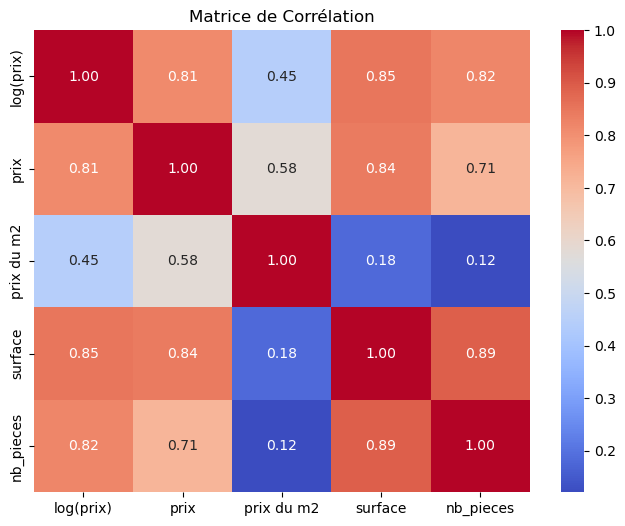

In [18]:
import seaborn as sns


colonnes_numériques = ['log(prix)', 'prix', 'prix du m2', 'surface', 'nb_pieces']

def graph_correlation_heatmap(listings: pd.DataFrame, numerical_cols: list):

    listings_numerique = listings[numerical_cols]
    matrice_corr = listings_numerique.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrice_corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de Corrélation")
    plt.show()

graph_correlation_heatmap(listings, colonnes_numériques)


Naturellement, le prix est corrélé positivement avec la surface du bien et son nombre de pièces. Pour le prix on observe une correlation forte, respectivement de 0.85 et 0.73. Intuitivement, si un bien est plus grand ou dispose de plus de pièces, il sera, toute chose égale par ailleurs, plus cher. Cependant, on observe que pour le prix du m2 les corrélations restent positives mais deviennent faibles (0.21 et 0.14 respectivement). Le fait que le prix du m2 soit corrélé positivement avec la surface suggère que l'augmentation du prix du bien surpasse l'augmentation de la surface. Ce phénomène peut paraître contre-intuitif pour certaines surfaces. Pour clarifier, nous analysons le coefficient de Pearson entre le prix/surface et la surface selon les quartiles de la surface.

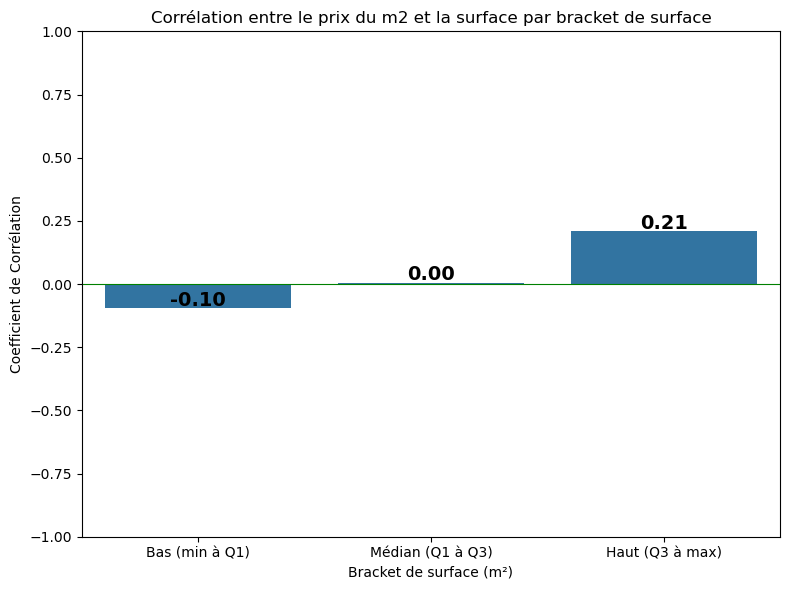

In [19]:
# Supposons que 'listings' est votre DataFrame existant
# Exemple d'initialisation (à remplacer par vos données réelles)
# listings = pd.read_csv('votre_fichier.csv')
def graph_bar_correlation_bracket(listings: pd.DataFrame):
    """
    Trace la corrélation entre 'prix du m2' et 'surface' par brackets de surface.

    Args:
        listings (pd.DataFrame): DataFrame contenant les colonnes 'prix du m2' et 'surface'.
    """
    # Calcul des quartiles
    Q1 = listings['surface'].quantile(0.25)
    Q2 = listings['surface'].quantile(0.50)
    Q3 = listings['surface'].quantile(0.75)
    
    # Définition des brackets
    bins = [listings['surface'].min(), Q1, Q3, listings['surface'].max()]
    labels = ['Bas (min à Q1)', 'Médian (Q1 à Q3)', 'Haut (Q3 à max)']
    listings['surface_bracket'] = pd.cut(listings['surface'], bins=bins, labels=labels, include_lowest=True)
    listings['surface_bracket'] = listings['surface_bracket'].astype(pd.CategoricalDtype(categories=labels, ordered=True))
    
    # Nettoyage des données
    listings_clean = listings.dropna(subset=['prix du m2', 'surface', 'surface_bracket'])
    
    # Calcul des corrélations par bracket
    correlation_dict = {}
    for bracket in labels:
        subset = listings_clean[listings_clean['surface_bracket'] == bracket]
        if len(subset) > 1:
            corr = subset['prix du m2'].corr(subset['surface'], method='pearson')
            correlation_dict[bracket] = corr
    
    # Conversion en DataFrame
    corr_listings = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Corrélation']).reset_index().rename(columns={'index': 'Bracket de Surface'})
    corr_listings['Bracket de Surface'] = pd.Categorical(corr_listings['Bracket de Surface'], categories=labels, ordered=True)
    corr_listings = corr_listings.sort_values('Bracket de Surface')
    
    # Tracé de la heatmap
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Bracket de Surface', y='Corrélation', data=corr_listings, order=labels)
    
    # Annotations
    for index, row in corr_listings.iterrows():
        plt.text(index, row.Corrélation+0.01, f"{row.Corrélation:.2f}", ha='center', fontsize = 14, fontweight ='bold')
    
    plt.title('Corrélation entre le prix du m2 et la surface par bracket de surface')
    plt.ylim(-1, 1)
    plt.ylabel('Coefficient de Corrélation')
    plt.xlabel('Bracket de surface (m²)')
    plt.axhline(0, color='green', linewidth=0.8)
    plt.tight_layout()
    plt.show()

graph_bar_correlation_bracket(listings)

Ce résultat souligne la diversité des segments du marché parisien. Une interprétation possible est que les grandes surfaces étant souvent destinés à des familles dont le budget est plus élevé, ceux-ci valorisent d'avantage la qualité du bien que son prix du m2, ainsi, une augmentation de la surface peut justifier un prix plus élevé du m2. La demande est moins élastique et la rareté accentue le prix/m² à mesure que la surface augmente.\
Pour les plus petits logements, le prix du m2 est initialement élevé car ils sont souvent des biens d'investissements (studio/appartement étudiant/Airbnb). De ce fait, ajouter quelques mètres carrés dans cette gamme ne rehausse pas forcément la valeur au m² si l’appartement reste, par exemple, un T1 (studio) plutôt qu’un T2. En d’autres termes, une studette de 15 m² à 18 m² ne modifie pas drastiquement l’attrait du bien pour les investisseurs. Le loyer potentiel n’augmente pas proportionnellement.\
Pour les biens "médians", souvent recherchés par la classe moyenne, la surface reste importante mais d'autres facteurs pèsent autant que le prix au m2. On peut citer l'étage, la localisation ou la luminosité.

Afin de préparer la modélisation du prix du m2 d'un logement parisien, il nous est nécessaire d'identifier les "outliers" qui pourrait nous poser des problèmes. On utilise une approche graphique.

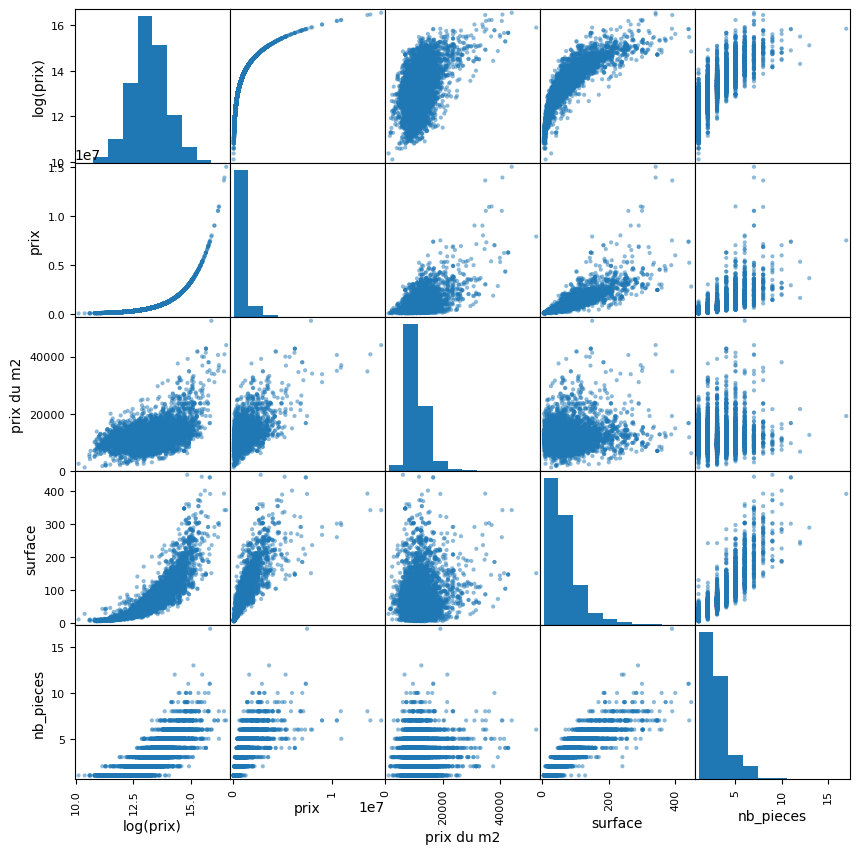

In [20]:
listings.dropna(inplace=True)

def graph_matrice_scatter(listings: pd.DataFrame, numerical_cols: list, figsize=(10, 10)):

    pd.plotting.scatter_matrix(listings[numerical_cols], figsize=figsize)
    plt.show()

graph_matrice_scatter(listings,colonnes_numériques)

Sur ce graphique on retrouve les différentes conclusions précédemment présentées. Nous voyons en diagonale les distributions plus ou moins asymétriques. De plus on retrouve à la première ligne les corrélations positives du log(prix) aux pièces et surface et les corrélations plus flous du prix du m2 à la deuxième ligne.
Ce graphique nous permet d'identifier les points extrêmes et de juger, au cas par cas, la pertinence de les conserver dans le cadre de notre modélisation.

Premier outlier : un logement avec un prix du m2 très élevé pour son nombre de pièces et sa surface.

In [21]:
listings.loc[listings["prix du m2"] > 50000]

,id,type,nb_pieces,loc,surface,prix,loc1,prix du m2,log(prix),surface_bracket
1141,apimo-7012481,Appartement,6,75008 Paris 8e (Triangle d'Or),150,7875000,Triangle d'Or,52500.0,15.879204,Haut (Q3 à max)


Il s'agit donc d'un appartement à 52500€ le m2 ce qui est près de 5 fois plus que la moyenne. Cependant, cela pourrait en partie s'expliquer par le sous-quartier exclusif du "Triangle d'Or", terme caractérisant une zone géographique prestigieuse et haut de gamme dans plusieurs villes françaises. Entres autres, à Paris, le Triangle d'Or est délimité par les avenues Montaigne, des Champs-Élysées et George-V. Comparons alors ce prix pharamineux aux autres logements offerts dans le Triangle d'Or.

In [22]:
listings.groupby('loc1')['prix du m2'].mean()["Triangle d'Or"]

np.float64(21487.143168422517)

La propriété a un prix par m2 deux fois plus élevé que la moyenne du quartier qui est elle même déjà exceptionnellement haute. afin de négliger l'effet inflationniste et non représentatif de ce bien sur notre modèle, nous décidons de supprimer cette offre.   

In [23]:
listings = listings.drop(index = listings['prix du m2'].idxmax())

Nous avons très peu de données pour les logements d'ultra luxe comportant au moins 13 pièces. De plus sur ce segment, les prix varient substantiellement car les appartements comportent des caractéristiques très exclusives qui justifient (pour certains) leur prix. Notre scraping ne nous permet cependant pas de quantifier ces caractéristiques spécifiques. Ainsi nous décidons d'enlever ces données non représentatives. (seulement 5 lignes)

In [24]:
listings = listings[listings['nb_pieces'] < 13]

Un autre point interpelle avec une surface supérieure à 400 m2 mais un prix qui serait autour de la moyenne des 150-200 m2. 

In [25]:
listings.loc[listings['surface']>400]

,id,type,nb_pieces,loc,surface,prix,loc1,prix du m2,log(prix),surface_bracket
4576,immo-facile-57398126,Appartement,11,75016 Paris 16e (Dauphine),440,7350000,Dauphine,16704.545455,15.810211,Haut (Q3 à max)
5018,hektor-hempton-1846,Appartement,7,75016 Paris 16e (Dauphine),442,5200000,Dauphine,11764.705882,15.464169,Haut (Q3 à max)
7616,iad-france-1651337,Maison,9,75020 Paris 20e (Télégraphe - Pelleport - Sain...,448,2770000,Télégraphe,6183.035714,14.834358,Haut (Q3 à max)
9399,immo-facile-57537751,Appartement,11,75016 Paris 16e (Dauphine),440,7350000,Dauphine,16704.545455,15.810211,Haut (Q3 à max)


On observe à la première ligne un bien à 1 500 000€ pour 500 m2 soit 3000€ du m2 ce qui semble impossible.

In [26]:
description_listings(listings)

Le logement médian à Paris fait 52 m2, comporte 2 pièces et coûte 530000€ soit 10381€ du m2 (avec frais d'agence et notarial)


,nb_pieces,surface,prix,prix du m2,log(prix)
count,10095.00,10095.00,10095.00,10095.00,10095.00
mean,2.78,64.72,745785.97,11037.08,13.19
std,1.52,48.62,791310.97,3571.98,0.79
min,1.00,4.00,25000.00,1203.70,10.13
25%,2.00,32.00,325000.00,8962.26,12.69
50%,2.00,52.00,530000.00,10380.95,13.18
75%,4.00,82.00,850000.00,12285.71,13.65
max,12.00,448.00,15000000.00,43988.27,16.52


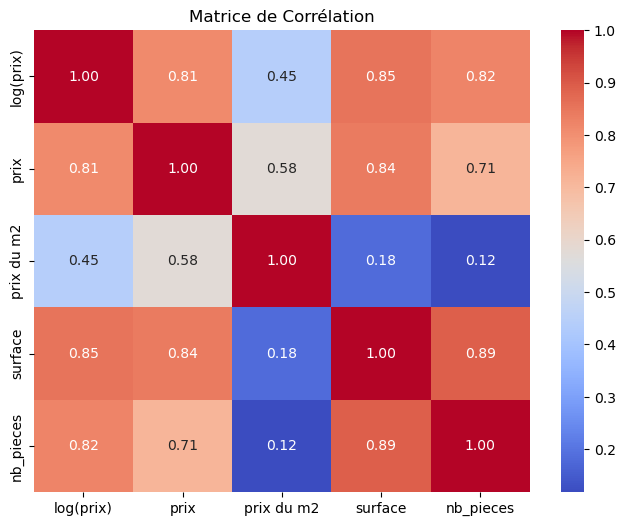

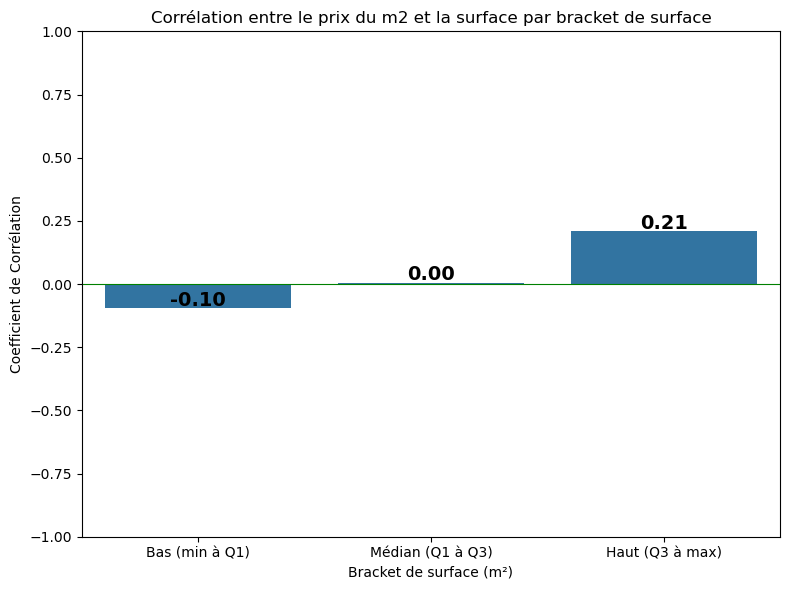

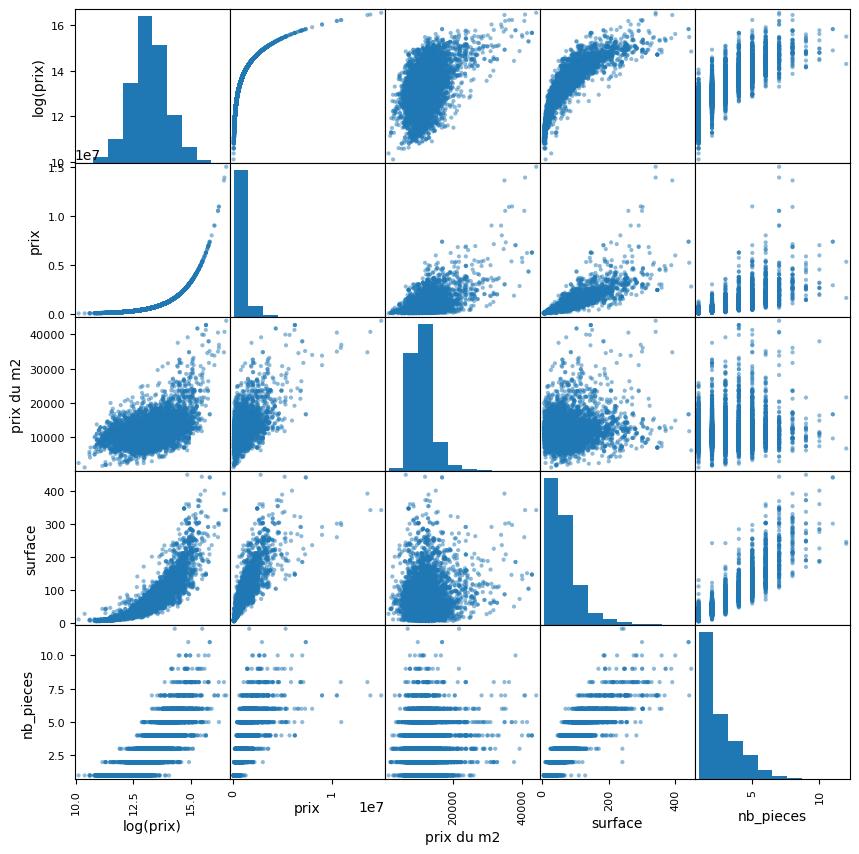

In [27]:
graph_correlation_heatmap(listings,colonnes_numériques)
graph_bar_correlation_bracket(listings)
graph_matrice_scatter(listings, colonnes_numériques)

On observe que nos retraitements n'impactent pas les conclusions précédemment mentionnées. Les distributions restent similaires tandis que les corrélations du prix du m2 avec la surface et le nombre de pièces diminuent. En effet ces corrélations étaient en partie liées au ultra haut de gamme que nous avons réduits. 

Avant de commencer la modélisation, nous souhaitons exploiter les données de localisation que nous avons collectées pour créer une carte représentant les niveaux de prix des différentes zones. Comme mentionné précédemment, nous disposons désormais de la latitude et de la longitude pour chaque zone. Pour ce faire, nous utilisons les bibliothèques "folium" et "geopy" afin de créer notre carte et de visualiser nos zones sur la carte.

In [28]:
import folium

In [29]:
# On reprend l'ancien dataframe "df"
# Rappel de la structure du dataframe
df.head()

,id,type,nb_pieces,loc,surface,prix,loc1,loc2,loc3,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,364000,Châtelet - Les Halles,Quartier Les Halles,75001,48.862509,2.346443,48.862373,2.345313,48.864614,2.334396
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,301000,Châtelet - Les Halles,Quartier Les Halles,75001,48.862509,2.346443,48.862373,2.345313,48.864614,2.334396
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000,Palais Royal,Quartier du Palais Royal,75001,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000,Saint-Germain - L'Auxerrois,Quartier Saint-Germain-l'Auxerrois,75001,48.859506,2.341347,48.860211,2.336299,48.864614,2.334396
4,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000,Vendôme,Quartier Vendôme,75001,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396


Nous commençons par créer une carte interactive centrée sur Paris. Nous sélectionnons les zones uniques en termes de coordonnées géographiques (latitude et longitude), puis nous ajoutons un marqueur pour chaque zone, en affichant son nom lorsque l'utilisateur clique sur le marqueur. Chaque marqueur est représenté par une icône bleue.

In [51]:
### CREATION DE LA CARTE ###

# Initialiser la carte centrée sur Paris
carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
df_unique = df.drop_duplicates(subset=['loc1_x', 'loc1_y'])
# Ajouter des points sur la carte pour les adresses avec coordonnées
for idx, row in df_unique.iterrows():
    lat = row['loc1_x']
    lon = row['loc1_y']
    if pd.notna(lat) and pd.notna(lon):
        folium.Marker(
            location=[lat, lon],
            popup=f"{row['loc1']}",  # Texte affiché lorsqu'on clique sur le point
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(carte)


In [52]:
## Affichage de la carte
carte

In [32]:
## Regrouper par 'loc1' et calculer la moyenne des prix, des surfaces et le nombre d'annonces
#resultat = df.groupby('loc1', as_index=False).agg(
#    moyenne_prix=('prix', 'mean'),      # Moyenne des prix
#    moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
#    nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
#    latitude=('loc1_x', 'first'),         # Latitude (première valeur)
#    longitude=('loc1_y', 'first')        # Longitude (première valeur))
#)
## Calculer la moyenne des prix au m²
#resultat['prix_m2'] = resultat['moyenne_prix'] / resultat['moyenne_surface']
#resultat.dropna(inplace=True)
#
#
#resultat2 = df.groupby('loc2', as_index=False).agg(
#    moyenne_prix=('prix', 'mean'),      # Moyenne des prix
#    moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
#    nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
#    latitude2=('loc2_x', 'first'),         # Latitude (première valeur)
#    longitude2=('loc2_y', 'first')        # Longitude (première valeur))
#)
## Calculer la moyenne des prix au m²
#resultat2['prix_m2'] = resultat2['moyenne_prix'] / resultat2['moyenne_surface']
#resultat2.dropna(inplace=True)
#
#resultat3 = df.groupby('loc3', as_index=False).agg(
#    moyenne_prix=('prix', 'mean'),      # Moyenne des prix
#    moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
#    nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
#    latitude3=('loc3_x', 'first'),         # Latitude (première valeur)
#    longitude3=('loc3_y', 'first')        # Longitude (première valeur))
#)
## Calculer la moyenne des prix au m²
#resultat3['prix_m2'] = resultat3['moyenne_prix'] / resultat3['moyenne_surface']
#resultat3.dropna(inplace=True)
## Supprimer les colonnes intermédiaires si elles ne sont pas nécessaires
##resultat = resultat[['loc1', 'prix_m2', 'nombre_annonces','loc1_x','loc1_y']]  # Garder uniquement loc1, prix_m2 et nombre d'annonces
#

In [33]:
#import matplotlib.colors as mcolors
#def prix_m2_to_color(prix_m2, min_price, max_price):
#    """
#    Map the prix_m2 to a color.
#    Green for lowest prix_m2, red for highest, with gradient in between.
#    """
#    # Normalize the prix_m2 between 0 and 1
#    norm = (prix_m2 - min_price) / (max_price - min_price)
#    # Use a colormap (e.g., 'RdYlGn') and invert it so that higher prices are red
#    cmap = plt.cm.get_cmap('RdYlGn_r')
#    # Get the RGBA color and convert it to HEX
#    color = mcolors.to_hex(cmap(norm))
#    return color
#
#min_price_m2 = resultat['prix_m2'].min()
#max_price_m2 = resultat['prix_m2'].max()
#min_annonces = resultat['nombre_annonces'].min()
#max_annonces = resultat['nombre_annonces'].max()
#
#
## Normaliser les tailles des points en fonction du nombre d'annonces
#min_radius = 5
#max_radius = 20
#
#def scale_radius(nombre_annonces):
#    return min_radius + (max_radius - min_radius) * (nombre_annonces - resultat['nombre_annonces'].min()) / (resultat['nombre_annonces'].max() - resultat['nombre_annonces'].min())
#
## Création de la carte
#carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
#
## Ajout des points
#for _, row in resultat.iterrows():
#    couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
#    radius = scale_radius(row['nombre_annonces'])  # Taille basée sur le nombre d'annonces
#    folium.CircleMarker(
#        location=[row['latitude'], row['longitude']],
#        radius=radius,  # Taille des points
#        color='black',  # Contour noir
#        fill=True,
#        fill_color=couleur,  # Remplissage rouge
#        fill_opacity=0.9,
#        popup=f"{row['loc1']}<br>Prix/m² : {row['prix_m2']:.2f} €<br>Nombre d'annonces : {row['nombre_annonces']}"
#    ).add_to(carte)
#
## Sauvegarder la carte
#carte.save("carte_prix_m2_taille.html")
#print("Carte créée : carte_prix_m2_taille.html")

In [34]:
#carte2 = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
#for _, row in resultat2.iterrows():
#    couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
#    radius = scale_radius(row['nombre_annonces'])  # Taille basée sur le nombre d'annonces
#    folium.CircleMarker(
#        location=[row['latitude2'], row['longitude2']],
#        radius=radius,  # Taille des points
#        color='black',  # Contour noir
#        fill=True,
#        fill_color=couleur,  # Remplissage rouge
#        fill_opacity=0.9,
#        popup=f"{row['loc2']}<br>Prix/m² : {row['prix_m2']:.2f} €<br>Nombre d'annonces : {row['nombre_annonces']}"
#    ).add_to(carte2)
#
## Sauvegarder la carte
#carte2.save("carte_prix_m2_taille_2.html")
#print("Carte créée : carte_prix_m2_taille_2.html")
#

In [35]:
#carte3 = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
#for _, row in resultat3.iterrows():
#    couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
#    radius = scale_radius(row['nombre_annonces'])  # Taille basée sur le nombre d'annonces
#    folium.CircleMarker(
#        location=[row['latitude3'], row['longitude3']],
#        radius=radius,  # Taille des points
#        color='black',  # Contour noir
#        fill=True,
#        fill_color=couleur,  # Remplissage rouge
#        fill_opacity=0.9,
#        popup=f"{row['loc3']}<br>Prix/m² : {row['prix_m2']:.2f} €<br>Nombre d'annonces : {row['nombre_annonces']}"
#    ).add_to(carte3)
#
## Sauvegarder la carte
#carte3.save("carte_prix_m2_taille_3.html")
#print("Carte créée : carte_prix_m2_taille_3.html")
#

In [38]:
# Plus la couleur est clair plus le prix/m² est faible. 
# Inversement, plus la couleur est élevée plus le prix/m² est élevée. 
# Afficher la carte : 
# carte


In [39]:
#carte2

In [40]:
#carte3

Nous générons maintenant trois cartes interactives, chacune représentant une localisation à une échelle différente. Chaque carte couvre une zone plus large, et le nombre de points diminue à mesure que l'on passe de loc1 à loc3. Les points de chaque carte sont des cercles dont la couleur varie en fonction du prix moyen au m², allant du rouge clair au rouge foncé, et la taille des cercles est proportionnelle au nombre d'annonces dans chaque zone.
Les zones dans chacune des cartes sont regroupées par niveau de localisation (loc1, loc2, loc3) et pour chaque niveau on utilise les prix moyens au m² et la taille moyenne des annonces. Cette approche permet de visualiser les différences de prix et d'intensité des annonces à différentes échelles géographiques. 

In [54]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming 'df' is your DataFrame and it's already loaded

# Définir les niveaux de localisation et leurs colonnes de latitude et longitude correspondantes
location_levels = {
    'loc1': {'lat_col': 'loc1_x', 'lon_col': 'loc1_y'},
    'loc2': {'lat_col': 'loc2_x', 'lon_col': 'loc2_y'},
    'loc3': {'lat_col': 'loc3_x', 'lon_col': 'loc3_y'}
}

# Fonction pour mapper le prix/m² à une couleur (rouge clair à rouge foncé)
def prix_m2_to_color(prix_m2, min_price, max_price):
    # Normaliser le prix/m² entre 0 et 1
    norm = (prix_m2 - min_price) / (max_price - min_price) if max_price != min_price else 0.5
    # Utiliser une palette de couleurs 'Reds' pour du rouge clair à rouge foncé
    cmap = plt.cm.get_cmap('Reds')
    # Obtenir la couleur RGBA et la convertir en HEX
    color = mcolors.to_hex(cmap(norm))
    return color

# Fonction pour normaliser la taille des points en fonction du nombre d'annonces
def scale_radius(nombre_annonces, min_annonces, max_annonces, min_radius=5, max_radius=20):
    return min_radius + (max_radius - min_radius) * (nombre_annonces - min_annonces) / (max_annonces - min_annonces)

cartes = []

# Itérer sur chaque niveau de localisation
for loc, cols in location_levels.items():
    print(f"Traitement de {loc}...")

    # Regrouper par le niveau de localisation actuel
    résultat = df.groupby(loc, as_index=False).agg(
        moyenne_prix=('prix', 'mean'),      # Moyenne des prix
        moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
        nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
        latitude=(cols['lat_col'], 'first'),  # Latitude (première valeur)
        longitude=(cols['lon_col'], 'first')  # Longitude (première valeur)
    )

    # Calculer la moyenne des prix au m²
    résultat['prix_m2'] = résultat['moyenne_prix'] / résultat['moyenne_surface']
    résultat.dropna(inplace=True)

    # Déterminer les valeurs min et max pour la normalisation
    min_price_m2 = résultat['prix_m2'].min()
    max_price_m2 = résultat['prix_m2'].max()
    min_annonces = résultat['nombre_annonces'].min()
    max_annonces = résultat['nombre_annonces'].max()

    # Création de la carte
    carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)  # Centrée sur Paris ; ajuster si nécessaire

    # Ajouter les points sur la carte
    for _, row in résultat.iterrows():
        couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
        radius = scale_radius(row['nombre_annonces'], min_annonces, max_annonces)  # Taille basée sur le nombre d'annonces
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=radius,  # Taille des points
            color='black',  # Contour noir
            fill=True,
            fill_color=couleur,  # Remplissage coloré
            fill_opacity=0.9,
            popup=(
                f"{row[loc]}<br>"
                f"Prix/m² : {row['prix_m2']:.2f} €<br>"
                f"Nombre d'annonces : {row['nombre_annonces']}"
            )
        ).add_to(carte)
    cartes.append(carte)

for i, carte in enumerate(cartes):
    print(f"Affichage de la carte {i+1} :")
    display(carte)

Traitement de loc1...
Traitement de loc2...
Traitement de loc3...
Affichage de la carte 1 :


/tmp/ipykernel_28532/3303092148.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')
/tmp/ipykernel_28532/3303092148.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')
/tmp/ipykernel_28532/3303092148.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


Affichage de la carte 2 :


Affichage de la carte 3 :


## IV. Modèle d'estimation ##

In [ ]:
## Code Maxime 

## Conclusion ##